In [ ]:
!pip install transformers datasets sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 5.3 MB/s 
     |████████████████████████████████| 451 kB 71.6 MB/s 
     |████████████████████████████████| 1.3 MB 60.3 MB/s 
     |████████████████████████████████| 7.6 MB 56.0 MB/s 
     |████████████████████████████████| 182 kB 77.6 MB/s 
     |████████████████████████████████| 132 kB 79.8 MB/s 
     |████████████████████████████████| 212 kB 77.5 MB/s 
     |████████████████████████████████| 127 kB 78.8 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
# loading data
from datasets import load_dataset
data = load_dataset("kde4", lang1="en", lang2="fr")
data

Generating train split:   0%|          | 0/210173 [00:00<?, ? examples/s]

Dataset kde4 downloaded and prepared to /root/.cache/huggingface/datasets/kde4/en-fr-lang1=en,lang2=fr/0.0.0/243129fb2398d5b0b4f7f6831ab27ad84774b7ce374cf10f60f6e1ff331648ac. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 210173
    })
})

In [ ]:
small = data["train"].shuffle(seed=42).select(range(210173//2)) # taking 50% of the data

In [ ]:
split = small.train_test_split(seed=42)

In [ ]:
split

DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 78814
    })
    test: Dataset({
        features: ['id', 'translation'],
        num_rows: 26272
    })
})

In [ ]:
split["train"][0]

{'id': '184719',
 'translation': {'en': 'This location is already defined. Do you want to replace the existing one?',
  'fr': 'Cet emplacement est déjà défini. Voulez -vous remplacer celui qui était défini précédemment & #160;?'}}

In [ ]:
from transformers import AutoTokenizer
checkpoint = "Helsinki-NLP/opus-mt-en-fr"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

Downloading:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/778k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/802k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.34M [00:00<?, ?B/s]

/usr/local/lib/python3.8/dist-packages/transformers/models/marian/tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [ ]:
en = split["train"][10]["translation"]["en"]
fr = split["train"][10]["translation"]["fr"]

en, fr

('Error in opening output file', "Erreur d'ouverture du fichier de sortie")

In [ ]:
# Tokenizing the inputs
inputs = tokenizer(en)
inputs

{'input_ids': [26088, 18, 4295, 8033, 1437, 0], 'attention_mask': [1, 1, 1, 1, 1, 1]}

In [ ]:
# tokenize the target sentence
# as target tokenizer context manager
with tokenizer.as_target_tokenizer():
  targets = tokenizer(fr)
targets

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:3578: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


{'input_ids': [34023, 20, 6, 4261, 22, 2428, 5, 5607, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
tokenizer.convert_ids_to_tokens(targets["input_ids"])

['▁Erreur',
 '▁d',
 "'",
 'ouverture',
 '▁du',
 '▁fichier',
 '▁de',
 '▁sortie',
 '</s>']

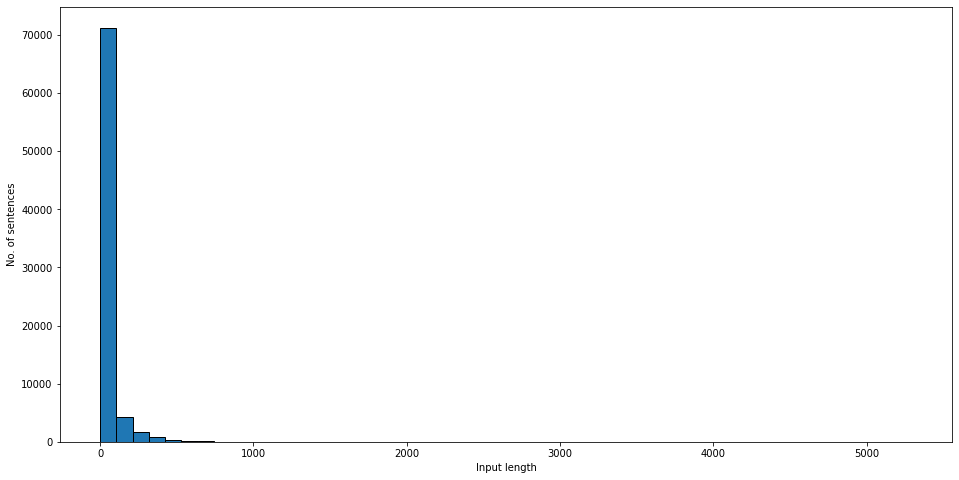

In [ ]:
# visualize the frequency of words in sentences (inputs)
import matplotlib.pyplot as plt

train = split["train"]["translation"]
input_lens = [len(tr["en"]) for tr in train]

plt.figure(figsize=(16,8))
plt.hist(input_lens, bins=50, edgecolor = "black")
plt.xlabel("Input length")
plt.ylabel("No. of sentences")
plt.show()
# plt.savefig('No. of sentences vs Input length.png')

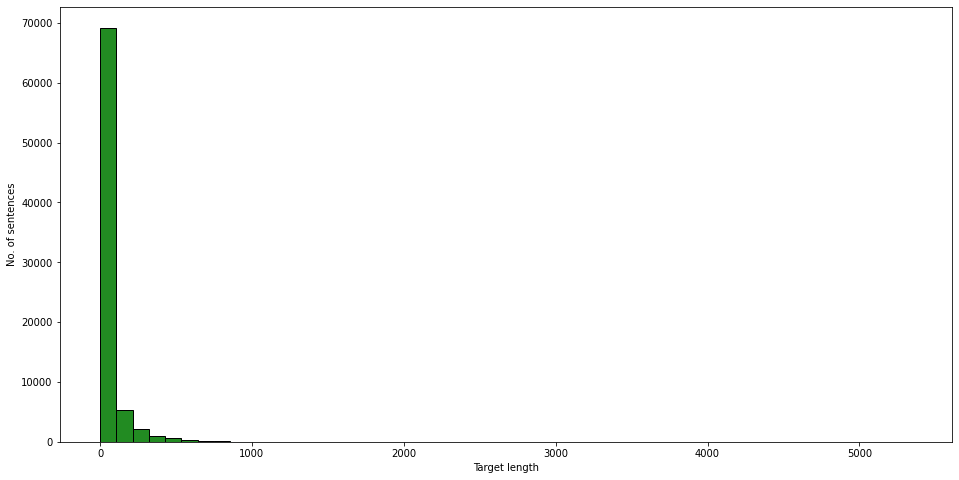

In [ ]:
# visualize the frequency of words in sentences (targets)
target_lens = [len(tr["fr"]) for tr in train]

plt.figure(figsize=(16,8))
plt.hist(target_lens, bins=50, edgecolor = "black", color="forestgreen")
plt.xlabel("Target length")
plt.ylabel("No. of sentences")
plt.show()
# plt.savefig('No. of sentences vs Target length.png')

In [ ]:
# creating Tokenizer function
max_input_len = 256
max_target_len = 256

def tokenizer_fn(batch):
  inputs = [x["en"] for x in batch["translation"]]
  targets = [x["fr"] for x in batch["translation"]]

  tokenized_inputs = tokenizer(
      inputs,
      max_length = max_input_len,
      truncation = True
  )

  with tokenizer.as_target_tokenizer():
    tokenized_targets = tokenizer(
        targets,
        max_length = max_target_len,
        truncation = True
    )

    tokenized_inputs["labels"] = tokenized_targets["input_ids"]

    return tokenized_inputs

In [ ]:
# storeing tokenized dataset
tokenized_datasets = split.map(
    tokenizer_fn,
    batched=True,
    remove_columns = split["train"].column_names,
)

  0%|          | 0/79 [00:00<?, ?ba/s]

  0%|          | 0/27 [00:00<?, ?ba/s]

In [ ]:
# View the tokenized dataset
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 78814
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 26272
    })
})

In [ ]:
# Creating the Seq2Seq transformers model
from transformers import AutoModelForSeq2SeqLM
model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)

Downloading:   0%|          | 0.00/301M [00:00<?, ?B/s]

In [ ]:
# using datacollator for padding and converting into torch tensor
from transformers import DataCollatorForSeq2Seq
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [ ]:
# Test out our datacollator
# It expects inputs as list of samples
# [tokenized_datasets["train"][i] for i in range(1,3)] creates list of len
batch = data_collator([tokenized_datasets["train"][i] for i in range(1,3)])
batch.keys()

dict_keys(['input_ids', 'attention_mask', 'labels', 'decoder_input_ids'])

In [ ]:
batch['labels']

tensor([[33261,    16,  2316, 21258,  1817,     9,     0,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100],
        [15479,    16,  3521,    17,   370,     5,     8,   421,     5,   372,
         12647,  1071,   634,  1150,   137,     6,    82,  6941,  9177,     9,
             9,  1819,     0]])

In [ ]:
print(type(batch["labels"]))

<class 'torch.Tensor'>


In [ ]:
# think of seq2seq RNNs - the decoder RNN must have "some" input
# it's just like a language model where we predict the next word from previous words
batch["decoder_input_ids"] 
# decoder_input_ids are just the shifted version of targets

tensor([[59513, 33261,    16,  2316, 21258,  1817,     9,     0, 59513, 59513,
         59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513,
         59513, 59513, 59513],
        [59513, 15479,    16,  3521,    17,   370,     5,     8,   421,     5,
           372, 12647,  1071,   634,  1150,   137,     6,    82,  6941,  9177,
             9,     9,  1819]])

In [ ]:
print(type(batch["decoder_input_ids"]))

<class 'torch.Tensor'>


In [ ]:
# The first token is a pad!
tokenizer.convert_ids_to_tokens(batch["decoder_input_ids"][0])

['<pad>',
 '▁Affiche',
 '▁les',
 '▁structures',
 '▁cristal',
 'line',
 's',
 '</s>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>']

In [ ]:
# the labels are one step ahead - just like a language model
tokenizer.convert_ids_to_tokens(batch["labels"][0])

['▁Affiche',
 '▁les',
 '▁structures',
 '▁cristal',
 'line',
 's',
 '</s>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>']

In [ ]:
split["train"][1]

{'id': '21914',
 'translation': {'en': 'Weight', 'fr': 'Affiche les structures cristallines'}}

In [ ]:
# installing scarebleu & bert-score for bleu_metric and bert_score_metric
!pip install sacrebleu bert-score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 118 kB 12.1 MB/s 
     |████████████████████████████████| 60 kB 7.0 MB/s 


In [ ]:
from datasets import load_metric

bleu_metric = load_metric("sacrebleu")
bert_metric = load_metric("bertscore")

<ipython-input-34-ec0ba0363219>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  bleu_metric = load_metric("sacrebleu")


In [ ]:
# targets must be in a list - for bleu there can be multiple
# acceptable reference translations 
bleu_metric.compute(predictions=["I love cats."], references=[["I love cats."]])

{'score': 100.00000000000004,
 'counts': [4, 3, 2, 1],
 'totals': [4, 3, 2, 1],
 'precisions': [100.0, 100.0, 100.0, 100.0],
 'bp': 1.0,
 'sys_len': 4,
 'ref_len': 4}

In [ ]:
from transformers.models import reformer
s = "Unreal Engine is a 3D computer graphics game engine developed by Epic Games, first showcased in the 1998 first-person shooter game Unreal."
bleu_metric.compute(predictions=[s], references=[[s]])

{'score': 100.00000000000004,
 'counts': [24, 23, 22, 21],
 'totals': [24, 23, 22, 21],
 'precisions': [100.0, 100.0, 100.0, 100.0],
 'bp': 1.0,
 'sys_len': 24,
 'ref_len': 24}

In [ ]:
# bleu score works on ngrams
# its not good for detecting similar words, or the word with same meaning
# bert_metricis useful here , it uses cosine similarities
bert_metric.compute(
    predictions=["I love cats."],
    references=[["I like cats."]],
    lang="en"
)

Downloading:   0%|          | 0.00/482 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.43G [00:00<?, ?B/s]

{'precision': [0.9888400435447693],
 'recall': [0.9888400435447693],
 'f1': [0.9888400435447693],
 'hashcode': 'roberta-large_L17_no-idf_version=0.3.12(hug_trans=4.25.1)'}

In [ ]:
bleu_metric.compute(
    predictions=["I love cats."], 
    references=[["I like cats."]]
    )

{'score': 35.35533905932737,
 'counts': [3, 1, 0, 0],
 'totals': [4, 3, 2, 1],
 'precisions': [75.0, 33.333333333333336, 25.0, 25.0],
 'bp': 1.0,
 'sys_len': 4,
 'ref_len': 4}

In [ ]:
# creating personal compute_metric function

import numpy as np

def compute_metrics(preds_and_labels):
  # preds are not logits, but token ids
  preds, labels = preds_and_labels

  # convert predictions into words
  decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

  #for any -100 label, replace with pad token id
  labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

  # convert labels into words
  decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

  # get rid of extraneous whitespace
  # and also, put targets into lists
  decoded_preds = [pred.strip() for pred in decoded_preds]
  decoded_labels = [[label.strip()] for label in decoded_labels]

  bleu = bleu_metric.compute(
      predictions = decoded_preds,
      references = decoded_labels
  )
  bert_score = bert_metric.compute(
      predictions = decoded_preds,
      references = decoded_labels,
      lang = "fr"
  )

  return {"bleu": bleu["score"], "bert_score": np.mean(bert_score["f1"])}

In [ ]:
# Creating training arguments
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    "finetuned-model",
    evaluation_strategy="no",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=3,
    predict_with_generate=True, # makes it autoregressive
    fp16=True,
)

In [ ]:
# trainer
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
    tokenizer= tokenizer,
    compute_metrics=compute_metrics,
)

Using cuda_amp half precision backend


In [ ]:
# let's check our metrics before we start
trainer.evaluate(max_length=max_target_len)

***** Running Evaluation *****
  Num examples = 26272
  Batch size = 64


Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-multilingual-cased/snapshots/fdfce55e83dbed325647a63e7e1f5de19f0382ba/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-multilingual-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.25.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size":

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--bert-base-multilingual-cased/snapshots/fdfce55e83dbed325647a63e7e1f5de19f0382ba/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--bert-base-multilingual-cased/snapshots/fdfce55e83dbed325647a63e7e1f5de19f0382ba/tokenizer_config.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-multilingual-cased/snapshots/fdfce55e83dbed325647a63e7e1f5de19f0382ba/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-multilingual-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "l

Downloading:   0%|          | 0.00/714M [00:00<?, ?B/s]

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--bert-base-multilingual-cased/snapshots/fdfce55e83dbed325647a63e7e1f5de19f0382ba/pytorch_model.bin
All the weights of BertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use BertModel for predictions without further training.


{'eval_loss': 1.700836420059204,
 'eval_bleu': 39.40262691314168,
 'eval_bert_score': 0.8593896406676607,
 'eval_runtime': 2152.5525,
 'eval_samples_per_second': 12.205,
 'eval_steps_per_second': 0.191}

In [ ]:
# may run out of GPU memory , should try to restart runtime
# or get a more powerful GPU
trainer.train()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 78814
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 7389
  Number of trainable parameters = 74609664


Step,Training Loss
500,1.413200
1000,1.237200
1500,1.178100
2000,1.133500
2500,1.095200
3000,0.998700
3500,0.988900
4000,0.981600
4500,0.960000
5000,0.954100


Saving model checkpoint to finetuned-model/checkpoint-2463
Configuration saved in finetuned-model/checkpoint-2463/config.json
Model weights saved in finetuned-model/checkpoint-2463/pytorch_model.bin
tokenizer config file saved in finetuned-model/checkpoint-2463/tokenizer_config.json
Special tokens file saved in finetuned-model/checkpoint-2463/special_tokens_map.json
Saving model checkpoint to finetuned-model/checkpoint-4926
Configuration saved in finetuned-model/checkpoint-4926/config.json
Model weights saved in finetuned-model/checkpoint-4926/pytorch_model.bin
tokenizer config file saved in finetuned-model/checkpoint-4926/tokenizer_config.json
Special tokens file saved in finetuned-model/checkpoint-4926/special_tokens_map.json
Saving model checkpoint to finetuned-model/checkpoint-7389
Configuration saved in finetuned-model/checkpoint-7389/config.json
Model weights saved in finetuned-model/checkpoint-7389/pytorch_model.bin
tokenizer config file saved in finetuned-model/checkpoint-7389/

TrainOutput(global_step=7389, training_loss=1.0298422842971817, metrics={'train_runtime': 1670.8533, 'train_samples_per_second': 141.51, 'train_steps_per_second': 4.422, 'total_flos': 5012424103034880.0, 'train_loss': 1.0298422842971817, 'epoch': 3.0})

In [ ]:
# let's evaluate our metrics again
trainer.evaluate(max_length=max_target_len)

***** Running Evaluation *****
  Num examples = 26272
  Batch size = 64


{'eval_loss': 0.9545300602912903,
 'eval_bleu': 51.23163377518078,
 'eval_bert_score': 0.8927632738506006,
 'eval_runtime': 2544.2599,
 'eval_samples_per_second': 10.326,
 'eval_steps_per_second': 0.162,
 'epoch': 3.0}

In [ ]:
trainer.save_model("my_saved_model")

Saving model checkpoint to my_saved_model
Configuration saved in my_saved_model/config.json
Model weights saved in my_saved_model/pytorch_model.bin
tokenizer config file saved in my_saved_model/tokenizer_config.json
Special tokens file saved in my_saved_model/special_tokens_map.json


In [ ]:
trainer.save_model("my_saved_model")

Saving model checkpoint to my_saved_model
Configuration saved in my_saved_model/config.json
Model weights saved in my_saved_model/pytorch_model.bin
tokenizer config file saved in my_saved_model/tokenizer_config.json
Special tokens file saved in my_saved_model/special_tokens_map.json


In [ ]:
from transformers import pipeline
translator = pipeline("translation", model="my_saved_model", device=0)

loading configuration file my_saved_model/config.json
Model config MarianConfig {
  "_name_or_path": "my_saved_model",
  "_num_labels": 3,
  "activation_dropout": 0.0,
  "activation_function": "swish",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "MarianMTModel"
  ],
  "attention_dropout": 0.0,
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 512,
  "decoder_attention_heads": 8,
  "decoder_ffn_dim": 2048,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 59513,
  "decoder_vocab_size": 59514,
  "dropout": 0.1,
  "encoder_attention_heads": 8,
  "encoder_ffn_dim": 2048,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 6,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "gradient_checkpointing": false,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "init_std": 0.02,
  "is_encoder_decoder": true,
 

In [ ]:
translator("I hope you are doing well.")

[{'translation_text': "J'espère que vous allez bien."}]